# What is the True Normal Human Body Temperature?

## Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv('human_body_temperature.csv')
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


## Is the distribution of body temperatures normal?

H0: Distribution of Body Temperature is normal.

H1: Distribution of Body Temperature is not normal.

Mean is 98.24923076923078
Standard Deviation is 0.7303577789050377


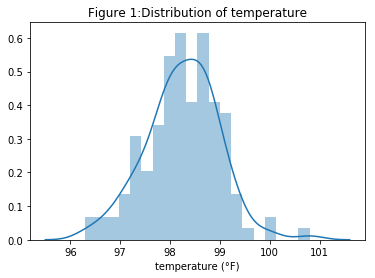

In [53]:
sns.distplot(df['temperature'],bins=20)
plt.xlabel('temperature (°F)')
plt.title('Figure 1:Distribution of temperature')
t=df['temperature']
mean=np.mean(t)
std=np.std(t)
print(f'Mean is {mean}')
print(f'Standard Deviation is {std}')

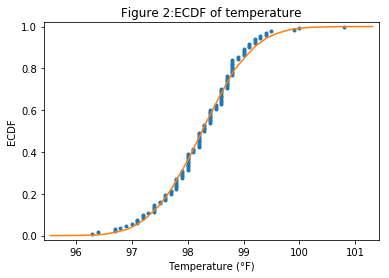

NormaltestResult(statistic=2.703801433319203, pvalue=0.2587479863488254)

In [54]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y
samples = np.random.normal(mean, std, size = 10000)
x,y=ecdf(t)
x_theor,y_theor=ecdf(samples)
_=plt.plot(x,y,marker='.',linestyle='none')
_=plt.plot(x_theor,y_theor)
_=plt.ylabel('ECDF')
_=plt.xlabel('Temperature (°F)')
plt.margins(0.02)
plt.title('Figure 2:ECDF of temperature')
plt.show()

from scipy.stats import normaltest

normaltest(df['temperature'])

Distribution of Body Temperature is normal. The p-value is approximately 0.25  based on normalization test.  It is bigger than 0.05; therefore, we cannot reject the null hypothesis. It means the distribution of Body Temperature is normal.

## Is the sample size large? Are the observations independent?

Since the distribution is normal,  the general rule of thumb for the large enough sample condition is that n>30.  

n=130 and 130>30

The sample size is large enough.

Because each temperature belongs to different people, the observations are independent. 

## Is the true population mean really 98.6 degrees F?

H0: The population mean is 98.6 °F.

H1: The population mean is not 98.6 °F.

In [69]:
def diff_of_means(data):
    diff = np.mean(data)-98.6
    return diff
def draw_bs_reps(data, func, size=1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data,size=len(data)))
    return bs_replicates
mean_diff= diff_of_means(t)
shifted_temp = t - mean + 98.6
bs_replicates = draw_bs_reps(shifted_temp, diff_of_means,10000)
p = np.sum(bs_replicates <= mean_diff)/ len(bs_replicates)
print('p-value =', p)

p-value = 0.0


I would use a one-sample test because I have only one sample. The sample size is large enough(n>30), so Z-score can be used.

In [72]:
from statsmodels.stats.weightstats import ztest

ztest(x1 = t, value = 98.6)

(-5.4548232923645195, 4.9021570141012155e-08)

The p-value is very small. Therefore, we can reject the null hypothesis. Let's check if anything changes for the t-test.

In [73]:
from scipy.stats import ttest_1samp

ttest_1samp(t, 98.6)

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

The p-value is still very small. Let's draw a small sample of size 10 from the data and repeat both frequentist tests for this small data sample.

In [74]:
small_sample = np.random.choice(t,10)

In [78]:
#Bootstrap test
diff_mean= diff_of_means(small_sample)
shift_temp = small_sample - np.mean(small_sample) + 98.6
bs_replicate = draw_bs_reps(shift_temp, diff_of_means,10000)
p = np.sum(bs_replicate <= diff_mean)/ len(bs_replicate)
print('p-value =', p)
#z-test
print('z-test results:',ztest(x1 = small_sample, value = 98.6))
#t-test
print('t-test results:',ttest_1samp(small_sample, 98.6))

p-value = 0.0042
z-test results: (-2.449489742783193, 0.014305878435429053)
t-test results: Ttest_1sampResult(statistic=-2.449489742783193, pvalue=0.03678749787978524)


The p-value is bigger when we used the small size of the sample. The proper test for this sample is the t-test. It is because of 10<30, and the standard deviation of the population is unknown.

## At what temperature should we consider someone's temperature to be "abnormal"?

In [82]:
bs_new_replicates = draw_bs_reps(t, np.mean, 10000)
conf_int = np.percentile(bs_new_replicates,[2.5,97.5])
print(conf_int)
# z value for % 95 confidence interval
z_value=1.96
marg_err = z_value * std / np.sqrt(len(t))
print(f'margin of error:{marg_err}')

[98.12538462 98.37461538]
margin of error:0.125550964802579


98.124 and 98.374 are between the 95% confidence interval. For temperature outside this range, we can consider being "abnormal". 

## Is there a significant difference between males and females in normal temperature?

H0: There is not a significant difference between males and females at normal temperature.

H1: There is a significant difference between males and females at normal temperature.

A two sample permutation test is the best approach to test the hypothesis.

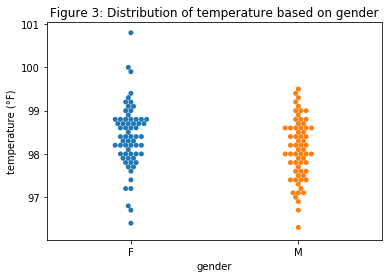

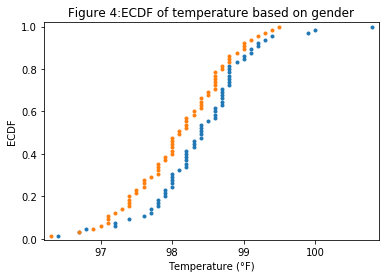

In [90]:
sns.swarmplot(x='gender',y='temperature', data=df)
plt.title('Figure 3: Distribution of temperature based on gender')
plt.xlabel('gender')
plt.ylabel('temperature (°F)')
plt.show()
data=df.set_index('gender')
F=data.loc['F']
M=data.loc['M']
x_f,y_f=ecdf(F['temperature'])
x_m,y_m=ecdf(M['temperature'])
_=plt.plot(x_f,y_f,marker='.',linestyle='none')
_=plt.plot(x_m,y_m,marker='.',linestyle='none')
_=plt.ylabel('ECDF')
_=plt.xlabel('Temperature (°F)')
plt.margins(0.02)
plt.title('Figure 4:ECDF of temperature based on gender')
plt.show()

In [92]:
def permutation_sample(data1, data2):
    data = np.concatenate((data1,data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2
def draw_perm_reps(data_1, data_2, func, size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)
    return perm_replicates
def dif_of_mean(data_1, data_2):
    return np.mean(data_1) - np.mean(data_2)
perm_replicates=draw_perm_reps(F['temperature'],M['temperature'],dif_of_mean,10000)
emp_mean=dif_of_mean(F['temperature'],M['temperature'])
p = np.sum(perm_replicates >= emp_mean) / len(perm_replicates)
print('p: ',p)

p:  0.0118


p value is less than 0.05. Therefore, we can reject the null hypothesis. 

## Key Findings

    1. The distribution of Body Temperature is normal.
    2. The sample size is large enough.
    3. Because each temperature belongs to different people, the observations are independent.
    4. The population mean is not 98.6 °F.
    5. Between 98.124 and 98.374 can consider being "abnormal"
    6. There is a significant difference between males and females at normal temperature.